# Softmax Regression from scratch
---
↳ Implement Batch Gradient Descent with early stopping for Softmax Regression (without using Scikit-Learn)

## What I Learned ?
---
- deeper understanding of gradient descent alogrithm
- understand the goal of each hyperparameters and gain insight to tune them
- learning to transform math equation to python code
- handeling matrix multiplication with numpy
- implementing different regularization algoritm 
---

## Summary
1. Load and preprocess the MNIST dataset
2. Softmax Regression Model
3. Ridge Regularization ($l_2$)
4. Early Stoping

In [1]:
import numpy as np
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(42)

## 1. Load and Preprocess the MNIST dataset
---
We made the choice to train our model on the __MNIST dataset__, a dataset composed of hand-written digits. This is a personal choice and the data are just use to implement the algorithm from scratch. Feel free to train your model on an other dataset.

 First, let's fetch the mnist dataset from openml. We will use Scikit-Learn `fetch_openml` function. _Note : it will be the first and last we will use Scikit-Learn in this notebook._

In [2]:
from sklearn.datasets import fetch_openml # the first and last time we will use Scikit learn in the notebook
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

### Normalize and Add the Bias Terme
We normalize the pixel between 0 and 1, and had the bias term for every instance ($\theta_0=1$)

In [3]:
X = mnist['data']/255
X_with_bias = np.c_[np.ones([len(X), 1]), X]
y = mnist['target'].astype(np.int)

The function bellow displays instance from the dataset. Feel free to explore the dataset a little bit more by using different index on the function `show_image`  

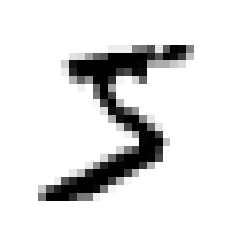

In [4]:
def show_image(x):
    plt.imshow(x.reshape(28,28), cmap=mpl.cm.binary)
    plt.axis("off")
    
show_image(X[0])
plt.show()

Let's explore the few first instance of this dataset

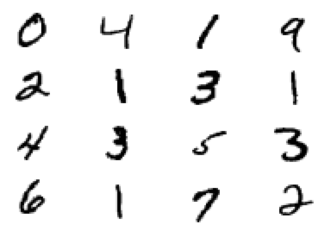

In [5]:
rows = 4
columns = 4
for i in range(rows):
    for j in range(columns):
        index = (rows * i + j )+ 1
        plt.subplot(4,4,index)
        show_image(X[index])
plt.show()

### Split the Dataset

Let's now __split the dataset into a training set, a validation set and a testing set__. As we can not use Scikit-learn, we will handle the splitting process with numpy and vanilla python. Instead of just using the method from Scikit learn `test_train_split` 

In [6]:
validation_ratio = 0.2
testing_ratio = 0.2
total_size = len(X) # number of instances

validation_size = int(validation_ratio * total_size)
testing_size = int(testing_ratio * total_size)
training_size = len(X) - validation_size - testing_size

random_index = np.random.permutation(total_size) 

X_train = X_with_bias[random_index[:training_size]]
y_train = y[random_index[:training_size]]
X_test = X_with_bias[random_index[training_size:-testing_size]]
y_test = y[random_index[training_size:-testing_size]]
X_val = X_with_bias[random_index[-validation_size:]]
y_val = y[random_index[-validation_size:]]

In [7]:
print(f"training size is composed of {X_train.shape[0]} instances")
print(f"testing size: {X_test.shape[0]}")
print(f"validation size: {X_val.shape[0]}")

training size is composed of 42000 instances
testing size: 14000
validation size: 14000


### Transform the Target into Binary Columns

The target are store as a class indices, an array-like of integers between 0 and 9. To be handled by the Softmax Regression algorithm we need to __transform the target into a binary column of target class probabilites__. Look at the example bellow to have a better understanding of the transformation.  

Let's create a simple function to handle it:

In [8]:
#  [2,3,...,6] → [[1,0,..,0],[0,1,..,0],..[0,0,..,0]]
def to_one_hot(y):
    n_classes = 10
    m = len(y)
    Y_one_hot = np.zeros((m,n_classes))
    Y_one_hot[np.arange(m),y] = 1
    return Y_one_hot

In [9]:
# array-like integer
y_train[:10]

array([8, 4, 8, 7, 7, 0, 6, 2, 7, 4])

In [10]:
# binary columns
to_one_hot(y_train[:10])

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [11]:
y_train_one_hot = to_one_hot(y_train)
y_test_one_hot = to_one_hot(y_test)
y_val_one_hot = to_one_hot(y_val)

🥳 The data are load and preprocess, ready to be used. Let's now create the Softmax Regression model and train the data on it

## 2. Softmax Regression model
---
__How to make prediction with the Softmax Regression model ?__

When given an instance $x$ to the Softmax Regression model, it computes a score $s_k(x)$ for each class k, then estimate the probability of each class by applying the _softmax function_ to the scores. Then, the Softmax Regression classifier predicts the class with the highest estimated probabilty.

_1. Softmax score for each class_
$$ s_k(x) = (\theta^{(k)})^T x$$

_2. Softmax function_
$$ \hat{p}_k = \dfrac{exp(s_k(x))}{\sideset{}{_{j=1}^K}\sum exp(s_j(x))}$$

_3. Classifier prediction_
$$ \hat{y} = \underset{k}{argmax }\, \sigma(s(x))_k = \underset{k}{argmax}\, (s(x))_k = \underset{k}{argmax}\, (\theta^{(k)})^T x$$

---

First, in the purpose to create a clean training loop, let's define a softmax function which take the score of each class k and transform it into a probability. Note that the some of the probabilty class is equal to one.

In [12]:
def softmax(score):
    """
    output: the prediction proba of each features for each class 
    """
    exps = np.exp(score)
    exps_sum = np.sum(exps,axis=1,keepdims=True)
    return exps / exps_sum 

In [13]:
n_inputs = X_train.shape[1] # number of features 
n_outputs = y_train_one_hot.shape[1] # number of classes 

__The training loop__: we need to translate the math equation into python code. 
Here is the equations we will need in the training loop
- _the cost function_
$J(\mathbf{\Theta}) =\dfrac{1}{m}\sum\limits{_{i=1}^m}^{}\sum\limits{_{k=1}^K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$
- _the equation for the gradient_
$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

Note that $\log\left(\hat{p}_k^{(i)}\right)$ may not be computable if $\hat{p}_k^{(i)} = 0$. So we will add a tiny value $\epsilon$ to $\log\left(\hat{p}_k^{(i)}\right)$ to avoid getting nan values.

<div class="alert alert-block alert-warning">
<b>Math equation to Python code</b>
    
All the math equation write above are made for a single instance on a single class. However, when we translate it to python code we need to transform each equations. The goal is to make them handle the full training set in one computation. That why this part can be tricky and it could be usefull to write the shape of each vectors and matrix on a white sheet to be sure we compute the thing we care about. 
</div>


In [14]:
from tqdm import tqdm

eta = 0.01 # learning rate
n_epochs = 5001 
m = X_train.shape[0] # number of instances
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs) # initialize the parameter matrix Θ

for epoch in tqdm(range(n_epochs)):
    score = X_train.dot(Theta)
    y_proba = softmax(score)
    loss = - np.mean(np.sum(y_train_one_hot * np.log(y_proba + epsilon), axis=1)) # cost function
    error = y_proba - y_train_one_hot
    if epoch % 500 == 0:
        print(epoch,loss)
    gradient = 1/m * X_train.T.dot(error)
    Theta = Theta - eta * gradient # GD

  0%|          | 3/5001 [00:00<07:54, 10.53it/s]

0 10.580270287108066


 10%|█         | 503/5001 [00:37<05:30, 13.62it/s]

500 4.9960662642184985


 20%|██        | 1003/5001 [01:14<04:49, 13.82it/s]

1000 3.355350898004822


 30%|███       | 1503/5001 [01:53<04:41, 12.44it/s]

1500 2.5955017344522804


 40%|████      | 2003/5001 [02:32<03:41, 13.52it/s]

2000 2.160977949708744


 50%|█████     | 2503/5001 [03:09<03:09, 13.15it/s]

2500 1.8803569244259697


 60%|██████    | 3003/5001 [03:48<02:26, 13.61it/s]

3000 1.684518346399604


 70%|███████   | 3503/5001 [04:27<02:03, 12.16it/s]

3500 1.54024257491497


 80%|████████  | 4003/5001 [05:05<01:12, 13.78it/s]

4000 1.429636225465455


 90%|█████████ | 4503/5001 [05:41<00:36, 13.80it/s]

4500 1.3420708073820946


100%|██████████| 5001/5001 [06:19<00:00, 13.16it/s]

5000 1.2708979165336893


🥳 The Softmax model is train, let's look at the parameters matrix Θ:

In [15]:
Theta

array([[-0.69851262, -1.09172218, -0.05833777, ...,  0.50560256,
         0.45588611, -0.11195584],
       [-0.73417545,  0.2977483 ,  0.45569972, ..., -1.26924032,
         0.666377  ,  0.18371664],
       [-0.1786894 , -0.61806051, -0.34842709, ..., -1.53962013,
        -1.05129735, -0.66000454],
       ...,
       [-0.47956893,  0.09524242,  0.48984114, ...,  0.14649828,
        -2.61444108, -0.29491227],
       [ 0.85326947, -0.61587497,  0.48652558, ..., -0.33588695,
         0.84646642, -0.31184075],
       [-0.63261925, -0.74082001, -0.95234518, ...,  0.92284027,
         0.35962962, -0.09082412]])

Let's make predictions for the validation set and check the accuracy score:

In [16]:
score = X_val.dot(Theta)
y_proba = softmax(score)
y_predict = np.argmax(y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_val)
accuracy_score

0.7457857142857143

Not bad the model are now trained! Let's try now to add some regularization and implement early stopping as well

## 3. Ridge regularization $(l_2)$
---
The code bellow is pretty much the same than the one above except that we add a regularize term in the loss function. We have also increased the learning rate 

$J(\mathbf{\Theta}) =$ _Cross entropy loss_ $ + \dfrac{1}{2}\alpha\sum{_{i=1}^n}^{}\sum{_{k=1}^K}{\theta_i^k}$

In [17]:
from tqdm import tqdm

eta = 0.1 # learning rate
n_epochs = 5001 
m = X_train.shape[0] # number of instances
epsilon = 1e-7
alpha = 0.1 # regularized hyperparameter

Theta = np.random.randn(n_inputs, n_outputs) # initialize the parameter matrix Θ

for epoch in tqdm(range(n_epochs)):
    score = X_train.dot(Theta)
    Y_proba = softmax(score)
    x_entropy_loss = - np.mean(np.sum(y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:])) # we don't regularize the bias
    loss = x_entropy_loss + alpha * l2_loss
    error = Y_proba - y_train_one_hot
    if epoch % 500 == 0:
        print(epoch,loss)
    gradient = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradient # GD

  0%|          | 0/5001 [00:00<?, ?it/s]

0 409.771870148023


 10%|█         | 502/5001 [00:37<05:29, 13.67it/s]

500 1.125056171763497


 20%|██        | 1002/5001 [01:14<05:22, 12.42it/s]

1000 1.0952433509940636


 30%|███       | 1502/5001 [01:52<04:15, 13.70it/s]

1500 1.0878614299165033


 40%|████      | 2002/5001 [02:30<04:40, 10.70it/s]

2000 1.0840112771619386


 50%|█████     | 2502/5001 [03:10<03:01, 13.76it/s]

2500 1.0819997315246455


 60%|██████    | 3002/5001 [03:47<02:25, 13.74it/s]

3000 1.0809470018601701


 70%|███████   | 3502/5001 [04:24<01:48, 13.85it/s]

3500 1.0803952038765292


 80%|████████  | 4002/5001 [05:00<01:12, 13.70it/s]

4000 1.0801055793508


 90%|█████████ | 4502/5001 [05:39<00:38, 12.92it/s]

4500 1.079953384742771


100%|██████████| 5001/5001 [06:16<00:00, 13.27it/s]

5000 1.0798733277070858


Let's make predictions for the validation set and check the accuracy score:

In [18]:
score = X_train.dot(Theta)
y_proba = softmax(score)
y_predict = np.argmax(y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_train)
accuracy_score

0.8653333333333333

## 4. Early Stoping
---
We need to mesure the loss on the validation set at each epoch and stop the model when the loss start growing

In [19]:
from tqdm import tqdm

eta = 0.1 # learning rate
n_epochs = 10001 
m = X_train.shape[0] # number of instances
epsilon = 1e-7
alpha = 0.1 # regularized hyperparameter
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs) # initialize the parameter matrix Θ

for epoch in tqdm(range(n_epochs)):
    score = X_train.dot(Theta)
    Y_proba = softmax(score)
    x_entropy_loss = - np.mean(np.sum(y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:])) # we don't regularize the bias
    loss = x_entropy_loss + alpha * l2_loss
    error = Y_proba - y_train_one_hot
    if epoch % 500 == 0:
        print(epoch,loss)
    gradient = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradient # GD
    
    # add early stoppingval loss
    score = X_val.dot(Theta)
    Y_proba = softmax(score)
    x_entropy_loss = - np.mean(np.sum(y_val_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:])) # we don't regularize the bias
    val_loss = x_entropy_loss + alpha * l2_loss
    if val_loss < best_loss:
        best_loss = val_loss
    else:
        print(epoch - 1, best_loss)
        print(epoch, loss, "Early stopping")
        break

  0%|          | 0/10001 [00:00<?, ?it/s]

0 410.66199594363377


  5%|▌         | 502/10001 [00:46<13:36, 11.64it/s]

500 1.1266584387249314


 10%|█         | 1002/10001 [01:29<12:49, 11.70it/s]

1000 1.0967011206795922


 15%|█▌        | 1502/10001 [02:11<12:07, 11.69it/s]

1500 1.0888807940345298


 20%|██        | 2002/10001 [02:55<11:41, 11.41it/s]

2000 1.0846679838080604


 25%|██▌       | 2503/10001 [03:39<10:37, 11.75it/s]

2500 1.0824061193559693


 30%|███       | 3001/10001 [04:22<09:56, 11.74it/s]

3000 1.0811935715656493


 35%|███▌      | 3501/10001 [05:05<09:16, 11.68it/s]

3500 1.0805434934282472


 40%|████      | 4002/10001 [05:49<08:34, 11.65it/s]

4000 1.0801944960031293


 45%|████▌     | 4501/10001 [06:35<07:48, 11.74it/s]

4500 1.0800066961106856


 50%|█████     | 5002/10001 [07:20<08:17, 10.05it/s]

5000 1.0799053276452044


 55%|█████▌    | 5502/10001 [08:03<06:23, 11.73it/s]

5500 1.0798504146478676


 59%|█████▊    | 5860/10001 [08:33<06:03, 11.40it/s]

5859 1.0736647580194172
5860 1.079827177092339 Early stopping


In [20]:
score = X_train.dot(Theta)
y_proba = softmax(score)
y_predict = np.argmax(y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_train)
accuracy_score

0.8652380952380953